In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                (df_sales['item_id']==3731)]
                                
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet['log_item_cnt_day_total'] = np.log(df_sales_fbprophet['item_cnt_day_total'])
df_sales_fbprophet=df_sales_fbprophet[['date','log_item_cnt_day_total']]
df_sales_fbprophet


,date,log_item_cnt_day_total
0,2015-04-14,8.249314
1,2015-04-15,6.864848
2,2015-04-16,6.194405
3,2015-04-17,5.874931
4,2015-04-18,5.916202
...,...,...
175,2015-10-27,1.609438
176,2015-10-28,2.302585
177,2015-10-29,2.079442
178,2015-10-30,2.079442


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "log_item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=-1
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2015-04-14,8.249314,-1,8.249314
1,2015-04-15,6.864848,-1,8.249314
2,2015-04-16,6.194405,-1,8.249314
3,2015-04-17,5.874931,-1,8.249314
4,2015-04-18,5.916202,-1,8.249314
...,...,...,...,...
175,2015-10-27,1.609438,-1,8.249314
176,2015-10-28,2.302585,-1,8.249314
177,2015-10-29,2.079442,-1,8.249314
178,2015-10-30,2.079442,-1,8.249314


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
            #growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

92

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=-1
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
267,2016-01-27,-1,8.249314
268,2016-01-28,-1,8.249314
269,2016-01-29,-1,8.249314
270,2016-01-30,-1,8.249314
271,2016-01-31,-1,8.249314


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
267,2016-01-27,-0.778378,-1.298083,-0.303085
268,2016-01-28,-0.866030,-1.366012,-0.324971
269,2016-01-29,-0.972748,-1.470905,-0.430324
270,2016-01-30,-1.094902,-1.641651,-0.609424
271,2016-01-31,-1.151956,-1.609069,-0.600491


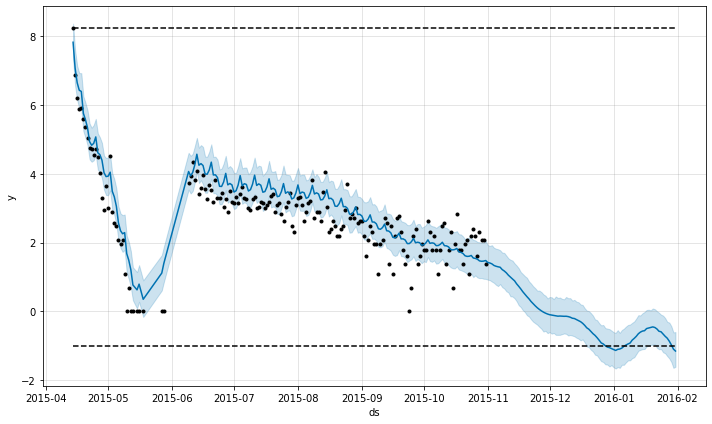

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'])

180    4.140869
181    4.084922
182    3.981440
183    3.802472
184    3.713635
185    3.654353
186    3.609157
187    3.372747
188    3.236369
189    3.069692
190    2.864799
191    2.706790
192    2.564593
193    2.431367
194    2.227907
195    2.075547
196    1.923060
197    1.770011
198    1.644823
199    1.535313
200    1.438102
201    1.332920
202    1.250502
203    1.176952
204    1.112194
205    1.059848
206    1.015999
207    0.978665
208    0.949719
209    0.926044
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()

69.65080967401231